<a href="https://colab.research.google.com/github/frikel12/Test-Project/blob/main/Twitter_Sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re
import multiprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
nltk.download("stopwords")

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'tensorflow'

# 2. Load the Data

In [ ]:
from os import listdir
from matplotlib import image
# Créer un objet de type list
loaded_images = list()
# On suppose que la base d'images est dans le dossier "CBIR_DataSet/obj_decoys" sur votre Google Drive

# Charger Drive dans Colab
from google.colab import drive
# drive.mount va permettre d'utiliser les fichiers sauvegarder dans Drive
# Il faut donner l'autorisation; un lien vous sera afficher.
# Il faut cliquer sur le lien pour récupérer une clés d'autorisation
drive.mount('/content/drive')

# Déclarer l'objet qui va contenir les noms des images
imageNames=[]

path='/content/drive/My Drive/CBIR_DataSet/obj_decoys'
# Boucler sur les images pour les lire et sauvegarder dans une variable
for filename in listdir(path):
    # Charger l'image
    imageNames.append(filename)
    img_data = image.imread(path+'/' + filename)
    # Ajouter l'image à l'objet loaded_images
    loaded_images.append(img_data)
    # Activer l'instruction ci-dessus pour afficher les nom de images et les tailles
    print(' %s %s ' % (filename, img_data.shape))

In [ ]:
col_names = ["target", "ids", "date", "flag", "user", "text"]

df = pd.read_csv('tweets.csv',
            encoding = "ISO-8859-1",
            names=col_names)

In [ ]:
df = df.sample(160000)
df.head()

,target,ids,date,flag,user,text
458467,0,2071902507,Sun Jun 07 20:05:51 PDT 2009,NO_QUERY,A_Diva_Inc,And he makes it
159285,0,1956805402,Thu May 28 22:44:09 PDT 2009,NO_QUERY,brigwyn,@superkathoid aww. that really sad. *hugs*
1074807,4,1967042488,Fri May 29 18:52:07 PDT 2009,NO_QUERY,oceanus17,@Wersching if they don't like it they can unfo...
1112180,4,1972365469,Sat May 30 09:05:19 PDT 2009,NO_QUERY,RiskyMissCash,@SimPlyMoReNa I'm lovely bout to go job hunti...
135368,0,1836509458,Mon May 18 08:07:28 PDT 2009,NO_QUERY,BiiBiiLa,i'm going to revise again exams i hate that !


# 3. Explore the Data

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 160000 entries, 458467 to 896367
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  160000 non-null  int64 
 1   ids     160000 non-null  int64 
 2   date    160000 non-null  object
 3   flag    160000 non-null  object
 4   user    160000 non-null  object
 5   text    160000 non-null  object
dtypes: int64(2), object(4)
memory usage: 8.5+ MB


In [ ]:
df.shape


(160000, 6)

In [ ]:
df.describe(include='all')


,target,ids,date,flag,user,text
count,160000.000000,1.600000e+05,160000,160000,160000,160000
unique,NaN,NaN,143832,1,123283,159414
top,NaN,NaN,Fri May 29 14:28:29 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,6,160000,59,22
mean,2.000000,1.998709e+09,NaN,NaN,NaN,NaN
std,2.000006,1.935839e+08,NaN,NaN,NaN,NaN
min,0.000000,1.467811e+09,NaN,NaN,NaN,NaN
25%,0.000000,1.956744e+09,NaN,NaN,NaN,NaN
50%,2.000000,2.001866e+09,NaN,NaN,NaN,NaN
75%,4.000000,2.177018e+09,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='target', ylabel='count'>

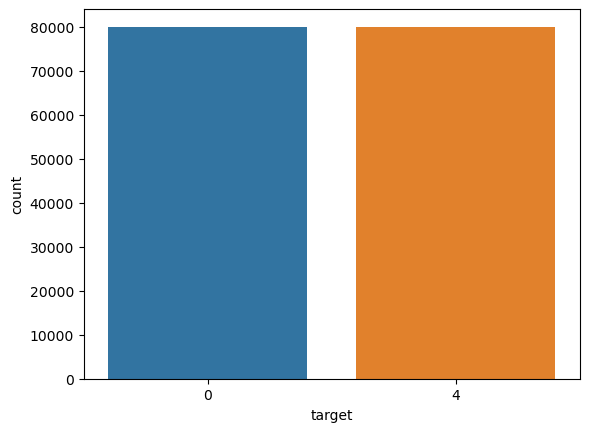

In [ ]:
sns.countplot(x=df['target'])

In [ ]:
df['target'].unique()

array([0, 1], dtype=int64)

In [ ]:
df['target'] = df['target'].replace(4, 1)

In [ ]:
df['target'].unique()

array([0, 1], dtype=int64)

In [ ]:
df = df.drop(['ids', 'date', 'flag','user'], axis = 1)
df.head()

,target,text
458467,0,And he makes it
159285,0,@superkathoid aww. that really sad. *hugs*
1074807,1,@Wersching if they don't like it they can unfo...
1112180,1,@SimPlyMoReNa I'm lovely bout to go job hunti...
135368,0,i'm going to revise again exams i hate that !


# 4. Preprocessing

In [ ]:
data = df['text']
labels = np.array(df['target'])

In [ ]:
data.iloc[1]

'@superkathoid aww. that really sad.  *hugs*'

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def split_into_words(text):
    words = text.split()
    return words

def to_lower_case(words):
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    return ' '.join(words)

def tweet(words):
    tweet_tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True,reduce_len=True)
    tweet = tweet_tokenizer.tokenize(words)
    return tweet


def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)


In [ ]:
data = data.apply(denoise_text)

In [ ]:
print('Before: {}'. format(list(df['text'][:2])))
print('---')
print('After: {}'. format(list(data[:2])))

Before: ['And he makes it ', '@superkathoid aww. that really sad.  *hugs*']
---
After: ['makes', 'superkathoid aww really sad hugs']


In [ ]:
X_train, X_test, y_train, y_test = test = train_test_split(data, labels,test_size=0.20,
                                                           random_state=1,
                                                           stratify = labels)

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)+1
VOCAB_SIZE

116467

In [ ]:
maxlen = max([len(x) for x in X_train])
maxlen = 50

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded_sequences = pad_sequences(train_sequences,maxlen=maxlen,padding='post',truncating='post')
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded_sequences = pad_sequences(test_sequences,maxlen=maxlen,padding='post',truncating='post')

In [ ]:
len(train_padded_sequences[6])


50

# 5. Data Modeling

In [ ]:
embedding_dim = 32

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE+1, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(embedding_dim,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(8,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid'),
    ])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            3726976   
                                                                 
 bidirectional (Bidirectiona  (None, 32)               6272      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1

In [ ]:
history = model.fit(train_padded_sequences, y_train,
                       validation_data = (test_padded_sequences, y_test),
                       epochs = 3)

Epoch 1/3
4000/4000 [==============================] - 329s 81ms/step - loss: 0.5469 - accuracy: 0.7240 - val_loss: 0.5014 - val_accuracy: 0.7575
Epoch 2/3
4000/4000 [==============================] - 319s 80ms/step - loss: 0.4776 - accuracy: 0.7737 - val_loss: 0.6082 - val_accuracy: 0.7479
Epoch 3/3
4000/4000 [==============================] - 321s 80ms/step - loss: 0.4518 - accuracy: 0.7870 - val_loss: 0.5210 - val_accuracy: 0.7361


In [ ]:
print(X_test.iloc[99],'label: ;',y_test[99])

well saw inkheart quite enjoyed really label: ; 1


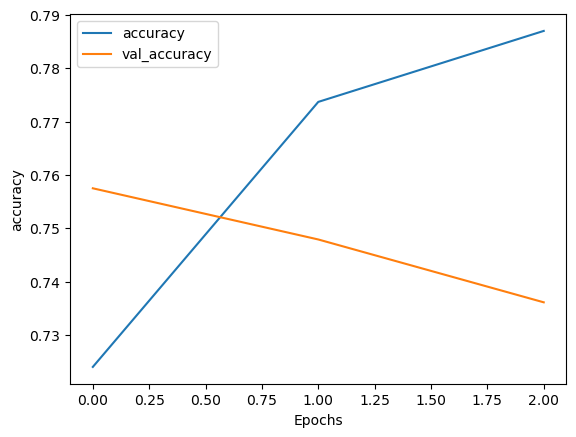

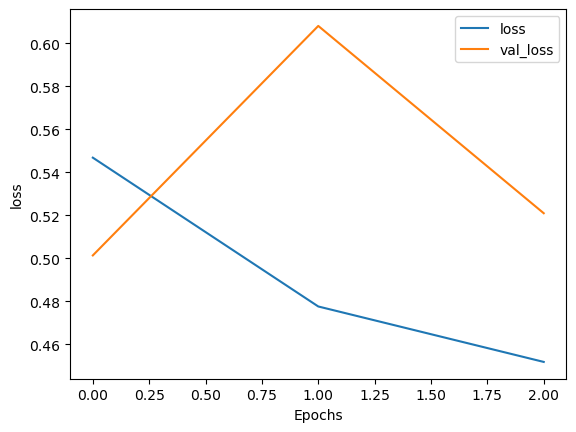

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(model, string):
    plt.plot(model.history[string])
    plt.plot(model.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
predicted_test=model.predict(X_test)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,predicted_test)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=[Etiquette_1,Etiquette_2],
            yticklabels=[Etiquette_1,Etiquette_2])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Réelle',fontsize=13)
plt.title('Matrice de confusion',fontsize=17)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
rapport = classification_report(y_test,predicted_test)

print('Rapport de Classification : \n',rapport)


import sklearn.metrics as metrics
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_test))
print("Recall : ", metrics.recall_score(y_test, predicted_test, average='macro'))
print("Precision: ", metrics.precision_score(y_test, predicted_test, average='macro'))
print("F1 score: ", metrics.f1_score(y_test, predicted_test, average='macro'))

In [ ]:
model.save('SentimentModel')
model.save_weights("Model Weights")

INFO:tensorflow:Assets written to: SentimentModel\assets


INFO:tensorflow:Assets written to: SentimentModel\assets
